# Introduction to 🤗 Diffusers

![diffusers_library](https://github.com/huggingface/diffusers/raw/main/docs/source/en/imgs/diffusers_library.jpg)


In this notebook, you'll train your first diffusion model to **generate images of butterflies 🦋.** Along the way, you'll learn about the core components of the 🤗 Diffusers library, which will provide a good foundation for the more advanced applications that we'll cover later in the course.

Let's dive in!

## What You Will Learn

In this notebook you will:

- See a powerful custom diffusion model pipeline in action (with information on how to make your own version)
- Create your own mini pipeline by:
  - Recapping the core ideas behind diffusion models
  - Loading in data from the Hub for training
  - Exploring how we add noise to this data with a scheduler
  - Creating and training the UNet model
  - Putting the pieces together into a working pipeline


## Step 1: Import libraries


In [1]:
# %pip install -U diffusers datasets transformers

In [23]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from huggingface_hub import notebook_login
from PIL import Image

warnings.filterwarnings("ignore")
notebook_login()

In [ ]:
def show_images(x):
    """Given a batch  of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy working"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im


device = "cuda" if torch.cuda.is_available() else "cpu"

## Step 2: Download the training dataset


In [ ]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader

dataset = load_dataset("huggan/smithsonian_butterflies_subset", split="train")

image_size = 32
batch_size = 64

# Define the data augmentation
transform = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transforms(examples):
    images = [transform(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transforms)

# Create a dataloader
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

Repo card metadata block was not found. Setting CardData to empty.


We can grab a batch of images and view some of them like so:


x shape: torch.Size([8, 3, 32, 32])


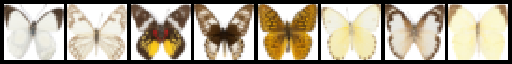

In [ ]:
xb = next(iter(train_loader))["images"].to(device)[:8]
print("x shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

## Step 3: Define the Scheduler

Our plan for training is to take these input images and add noise to them, then feed the noisy images to the model. And during inference, we will use the model predictions to iteratively remove noise. In `diffusers`, these processes are both handled by the **scheduler**.

The noise schedule determines how much noise is added at different timesteps. Here's how we might create a scheduler using the default settings for 'DDPM' training and sampling (based on the paper ["Denoising Diffusion Probabilistic Models"](https://arxiv.org/abs/2006.11239)):


In [31]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathbf{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>

That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. Now, we don't necessarily want to do this operation 500 times to get $x_{500}$ so we have another formula to get $x_t$ for any t given $x_0$: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathbf{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>

The maths notation always looks scary! Luckily the scheduler handles all that for us. We can plot $\sqrt{\bar{\alpha}_t}$ (labelled as `sqrt_alpha_prod`) and $\sqrt{(1 - \bar{\alpha}_t)}$ (labelled as `sqrt_one_minus_alpha_prod`) to view how the input (x) and the noise are scaled and mixed across different timesteps:


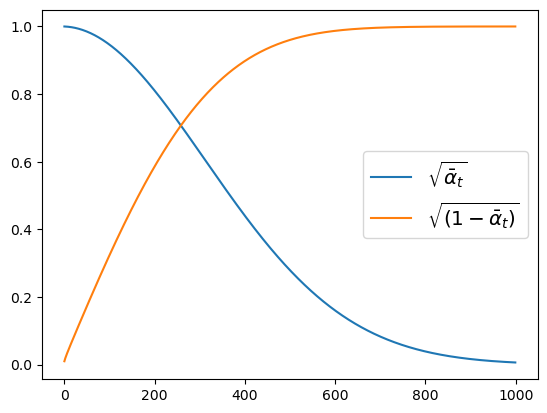

In [ ]:
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")
plt.show()

Noisy X shape torch.Size([8, 3, 32, 32])


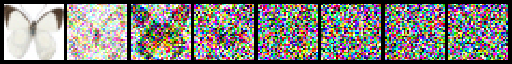

In [36]:
timesteps = torch.linspace(0, 999, 8).long().to(device)
noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)
show_images(noisy_xb).resize((8 * 64, 64), resample=Image.NEAREST)

## Step 4: Define the model

Now we come to the core component: the model itself.

Most diffusion models use architectures that are some variant of a [U-net](https://arxiv.org/abs/1505.04597) and that's what we'll use here.

![](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/unet-model.png)

In a nutshell:

- the model has the input image go through several blocks of ResNet layers, each of which halves the image size by 2
- then through the same number of blocks that upsample it again.
- there are skip connections linking the features on the downsample path to the corresponding layers in the upsample path.

A key feature of this model is that it predicts images of the same size as the input, which is exactly what we need here.

Diffusers provides us a handy `UNet2DModel` class which creates the desired architecture in PyTorch.

Let's create a U-net for our desired image size.
Note that `down_block_types` correspond to the downsampling blocks (green on the diagram above), and `up_block_types` are the upsampling blocks (red on the diagram):


In [ ]:
from diffusers import UNet2DModel

# Create a model
model = UNet2DModel(
    sample_size=image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
model.to(device)

## Step 5: Create a Training Loop

Time to train! Below is a typical optimization loop in PyTorch, where we run through the data batch by batch and update the parameters of our model each step using an optimizer - in this case the AdamW optimizer with a learning rate of 0.0004.

For each batch of data, we

- Sample some random timesteps
- Noise the data accordingly
- Feed the noisy data through the model
- Compare the model predictions with the target (i.e. the noise in this case) using mean squared error as our loss function
- Update the model parameters via `loss.backward()` and `optimizer.step()`

During this process we also log the losses over time for later plotting.

NB: This code takes nearly 10 minutes to run - feel free to skip these two cells and use the pretrained model if you are in a hurry. Alternatively, you can explore how reducing the number of channels in each layer via the model definition above can speed things up.


In [45]:
# Set the noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Training loop
optimizer = torch.optim.Adam(model.parameters(), lr=4e-4)

losses = []

for epoch in range(30):
    for step, batch in enumerate(train_loader):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        )

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        losses.append(loss.item())

        # Update the model parameters with optimizer
        optimizer.step()
        optimizer.zero_grad()

    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_loader) :]) / len(train_loader)
        print(f"Epoch: {epoch + 1}, loss: {loss_last_epoch}")

Epoch: 5, loss: 0.11773374350741506
Epoch: 10, loss: 0.08643794571980834
Epoch: 15, loss: 0.0735660761129111
Epoch: 20, loss: 0.06289323698729277
Epoch: 25, loss: 0.06280068820342422
Epoch: 30, loss: 0.058541153091937304


Plotting the loss, we see that the model rapidly improves initially and then continues to get better at a slower rate (which is more obvious if we use a log scale as shown on the right):


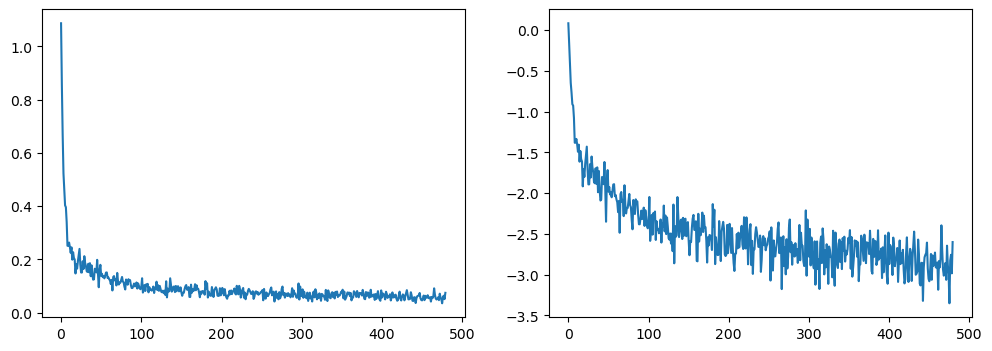

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

## Step 6: Generate Images

How do we get images with this model?


### Option 1: Creating a pipeline:


  0%|          | 0/1000 [00:00<?, ?it/s]

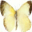

In [49]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

pipeline_output = image_pipe()
pipeline_output.images[0]

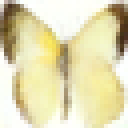

In [ ]:
img = pipeline_output.images[0]

large_img = img.resize((128, 128), resample=Image.NEAREST)

from IPython.display import display

display(large_img)

We can save a pipeline to a local folder like so:


In [55]:
# image_pipe.save_pretrained("my_pipeline")

### Option 2: Writing a Sampling Loop

We begin with random noise, and run through the scheduler timesteps from most to least noisy, removing a small amount of noise each step based on the model prediction:


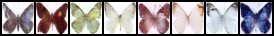

In [56]:
# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

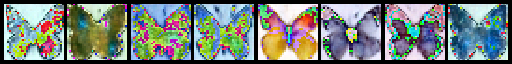

In [57]:
import torch
from torchvision.utils import make_grid
from torchvision import transforms as T
from PIL import Image
from IPython.display import display

# Random starting point (8 random images):
sample = torch.randn(8, 3, 32, 32).to(device)

# Reverse diffusion process
for t in noise_scheduler.timesteps:
    with torch.no_grad():
        residual = model(sample, t).sample
    sample = noise_scheduler.step(residual, t, sample).prev_sample

# Convert final batch to a grid
grid = make_grid(sample.cpu(), nrow=8)  # 8 images in one row

# Convert to PIL image and resize to something larger (e.g., 512x64 or 1024x128)
to_pil = T.ToPILImage()
img = to_pil(grid)

# Resize for display
large_img = img.resize((8 * 64, 64), resample=Image.NEAREST)

# Display in notebook
display(large_img)

The `noise_scheduler.step()` function does the maths required to update `sample` appropriately. There are a number of sampling methods - in the next unit we'll see how we can swap in a different sampler to speed up image generation with existing models, and talk more about the theory behind sampling from diffusion models.
